In [12]:
# Import required modules
import cv2 as cv
import math
import time
from google.colab.patches import cv2_imshow
# import argparse

def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

faceProto = "opencv_face_detector.pbtxt"
faceModel = "opencv_face_detector_uint8.pb"

ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"

genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20

def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        # print("Gender Output : {}".format(genderPreds))
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print("Age Output : {}".format(agePreds))
        print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace

Gender : Male, conf = 1.000
Age Output : [[1.1039142e-09 2.3243405e-08 3.5186915e-06 2.5091245e-05 9.9995363e-01
  1.6569789e-05 9.2914723e-07 1.8350761e-07]]
Age : (25-32), conf = 1.000


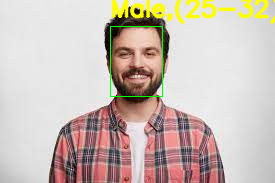

In [14]:
input = cv.imread("image.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

Gender : Male, conf = 1.000
Age Output : [[5.2902845e-07 4.2580933e-07 1.2246474e-04 4.2172280e-05 9.6185130e-01
  2.1459540e-02 1.6460970e-02 6.2668521e-05]]
Age : (25-32), conf = 0.962


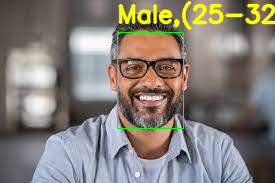

In [15]:
input = cv.imread("image1.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

Gender : Male, conf = 0.999
Age Output : [[4.6919464e-08 2.1333205e-08 1.5614593e-07 2.9017517e-07 2.6616558e-06
  1.2477439e-04 8.9984673e-01 1.0002531e-01]]
Age : (48-53), conf = 0.900
Gender : Male, conf = 1.000
Age Output : [[2.7533292e-04 1.4385054e-04 3.0866748e-04 6.0939207e-04 2.3807952e-02
  2.1682272e-02 9.3373966e-01 1.9432923e-02]]
Age : (48-53), conf = 0.934


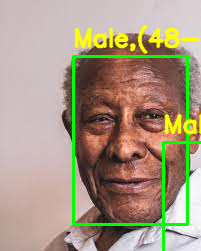

In [19]:
input = cv.imread("image2.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

In [ ]:
import cv2
cap = cv2.VideoCapture('video.mp4')
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = age_gender_detector(frame)
  out.write(output)
out.release()
print("Done processing video")

Processing Video...
Gender : Male, conf = 1.000
Age Output : [[5.3387463e-08 1.0340127e-07 1.8681514e-05 1.4009873e-05 9.7441363e-01
  2.5127327e-02 3.6621344e-04 5.9934686e-05]]
Age : (25-32), conf = 0.974
Gender : Male, conf = 1.000
Age Output : [[4.5980318e-08 9.6643625e-08 1.8316126e-05 1.2341026e-05 9.7947824e-01
  2.0115115e-02 3.2659704e-04 4.9329516e-05]]
Age : (25-32), conf = 0.979
Gender : Male, conf = 1.000
Age Output : [[4.44041532e-08 6.40261817e-08 1.30595345e-05 1.17655645e-05
  9.61571991e-01 3.80099379e-02 3.37808044e-04 5.52474521e-05]]
Age : (25-32), conf = 0.962
Gender : Male, conf = 1.000
Age Output : [[3.1908144e-08 7.3774515e-08 1.9211795e-05 1.0479284e-05 9.8575169e-01
  1.4029328e-02 1.6299516e-04 2.6030890e-05]]
Age : (25-32), conf = 0.986
Gender : Male, conf = 1.000
Age Output : [[4.0474088e-08 7.9481175e-08 2.3370021e-05 1.4927285e-05 9.7704577e-01
  2.2656826e-02 2.2021044e-04 3.8776638e-05]]
Age : (25-32), conf = 0.977
Gender : Male, conf = 1.000
Age Outpu